<a href="https://colab.research.google.com/github/2303A52430/explainable-AI-LAB/blob/main/x_ai_ass_5_2430.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [3]:
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = Fals

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [5]:
import shap

In [6]:
try:
    import lime
    from lime import lime_tabular
    has_lime = True
except Exception:
    has_lime = False

In [7]:
import seaborn as sns
sns.set(style='whitegrid')

In [9]:
DATA_PATH = '/tmp/data.csv' # Define the path to your data file

if not os.path.exists(DATA_PATH):
    print(f"{DATA_PATH} not found. Please upload it.")
else:
    print(f"Using data from {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    print("Dataset loaded. Shape:", df.shape)
    display(df.head())

/tmp/data.csv not found. Please upload it.


In [10]:
try:
    df_info = df.info()
except Exception:
    pass

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV (update the path/filename)
df = pd.read_csv("/content/co_emissions.csv")

# look at the first few rows
print(df.head())
print(df.columns)

        Entity Code  Year  Annual CO₂ emissions
0  Afghanistan  AFG  1949               14656.0
1  Afghanistan  AFG  1950               84272.0
2  Afghanistan  AFG  1951               91600.0
3  Afghanistan  AFG  1952               91600.0
4  Afghanistan  AFG  1953              106256.0
Index(['Entity', 'Code', 'Year', 'Annual CO₂ emissions'], dtype='object')


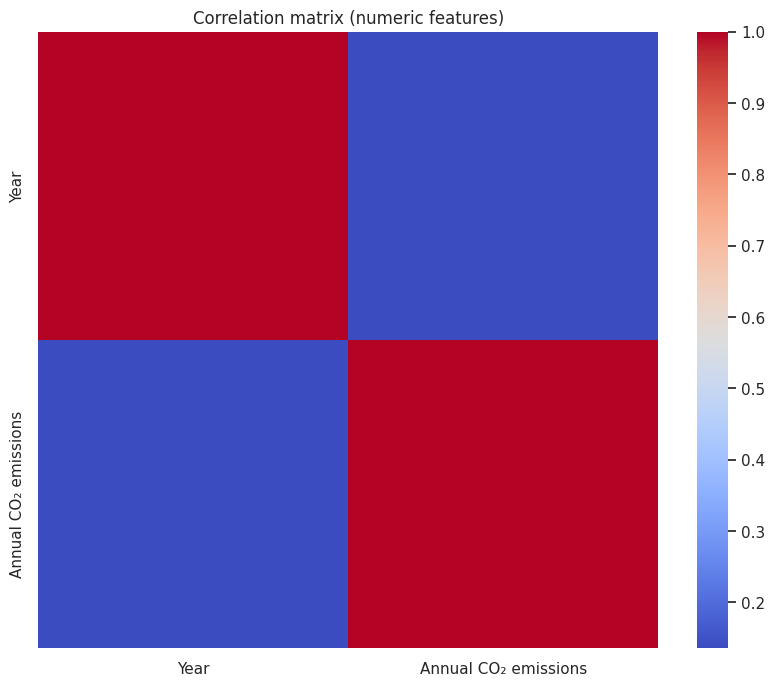

In [13]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.title('Correlation matrix (numeric features)')
    plt.show()

In [14]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# Define target_col before using it
if 'CO2_emissions' in df.columns:
    target_col = 'CO2_emissions'
else:
    # try searching for plausible target columns
    candidates = [c for c in df.columns if 'co2' in c.lower() or 'emiss' in c.lower()]
    target_col = candidates[0] if candidates else df.columns[-1]
    print('Auto-selected target column:', target_col)

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != target_col]

Auto-selected target column: Annual CO₂ emissions


In [15]:
print('Categorical columns:', cat_cols)
print('Numerical columns:', num_cols)

Categorical columns: ['Entity', 'Code']
Numerical columns: ['Year']


In [16]:
if 'population' in df.columns:
    df['co2_per_capita'] = df[target_col] / (df['population'].replace({0: np.nan}))
    num_cols.append('co2_per_capita')

In [17]:
for col in num_cols:
    if (df[col] > 0).all() and df[col].skew() > 1:
        df[col + '_log'] = np.log1p(df[col])
        num_cols.append(col + '_log')

In [18]:
numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

In [19]:
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [20]:
preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, num_cols),
('cat', categorical_transformer, cat_cols)
],
remainder='drop'
)

In [ ]:
all_cols = num_cols + cat_cols
unique_cols = list(set(all_cols))
X = df[unique_cols].copy()
y = df[target_col].copy()

In [25]:
models = {
'LinearRegression': LinearRegression(),
'Ridge': Ridge(alpha=1.0),
'Lasso': Lasso(alpha=0.01),
'DecisionTree': DecisionTreeRegressor(random_state=42),
'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
'SVR': SVR()
}

In [26]:
if has_xgb:
    models['XGBoost'] = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [27]:
def build_mlp(input_dim):
    model = tf.keras.models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [28]:
rf = models['RandomForest']
try:
    importances = rf.feature_importances_
    fi = pd.Series(importances, index=feature_names)
    fi_sorted = fi.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    fi_sorted.plot(kind='bar')
    plt.title('Random Forest Top Feature Importances')
    plt.show()
except Exception as e:
    print('Could not compute feature importances:', e)

Could not compute feature importances: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
